In [ ]:
#importing bunch of libraries that would be needed in future
import pandas as pd
import numpy as np
import gc,os
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
os.chdir('/content/gdrive/My Drive/santander_transcation_prediction')

### **Downloading dataset from kaggle to google drive**

In [ ]:

# from google.colab import files
# files.upload() #this will prompt you to update the json

# !pip install -q kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !ls ~/.kaggle
# !chmod 600 /root/.kaggle/kaggle.json  # set permission


In [ ]:
# #Download required dataset / competition files to a folder of your choice
# !kaggle competitions download -c santander-customer-transaction-prediction 


In [ ]:
!ls

modified_test.csv   sample_submission.csv.zip  train.csv.zip
modified_train.csv  test.csv.zip


### **Loading Train & Test Data**

*TRAIN DATA*

In [ ]:
train_df=pd.read_csv('train.csv.zip')

In [ ]:
train_df.head()

ID_code  target    var_0   var_1  ...  var_196  var_197  var_198  var_199
0  train_0       0   8.9255 -6.7863  ...   7.8784   8.5635  12.7803  -1.0914
1  train_1       0  11.5006 -4.1473  ...   8.1267   8.7889  18.3560   1.9518
2  train_2       0   8.6093 -2.7457  ...  -6.5213   8.2675  14.7222   0.3965
3  train_3       0  11.0604 -2.1518  ...  -2.9275  10.2922  17.9697  -8.9996
4  train_4       0   9.8369 -1.4834  ...   3.9267   9.5031  17.9974  -8.8104

[5 rows x 202 columns]

In [ ]:
print("Number of data point in training data =",train_df.shape[0])
print("Number of features in training data =",train_df.shape[1])

Number of data point in training data = 200000
Number of features in training data = 202


In [ ]:
# Y_train=train_df['target']
# X_train=train_df.drop(['target','ID_code'],axis=1)

In [ ]:
train_df_0=train_df[train_df['target']==0]  # dataframe with rows whose target is 0
train_df_1=train_df[train_df['target']==1]  # dataframe with rows whose target is 0


In [ ]:
target_0_index=train_df_0.index
target_1_index=train_df_1.index


*TEST DATA*

In [ ]:
test_df=pd.read_csv('test.csv.zip')

In [ ]:
test_df.head()

ID_code    var_0    var_1    var_2  ...  var_196  var_197  var_198  var_199
0  test_0  11.0656   7.7798  12.9536  ...   4.3654  10.7200  15.4722  -8.7197
1  test_1   8.5304   1.2543  11.3047  ...  -1.4852   9.8714  19.1293 -20.9760
2  test_2   5.4827 -10.3581  10.1407  ...  -7.1086   7.0618  19.8956 -23.1794
3  test_3   8.5374  -1.3222  12.0220  ...   3.9567   9.2295  13.0168  -4.2108
4  test_4  11.7058  -0.1327  14.1295  ...  -5.1612   7.2882  13.9260  -9.1846

[5 rows x 201 columns]

In [ ]:
print("Number of data point in test data =",test_df.shape[0])
print("Number of features in test data =",test_df.shape[1])

Number of data point in test data = 200000
Number of features in test data = 201


In [ ]:

# X_test=test_df.drop(['ID_code'],axis=1)

In [ ]:
col=[f'var_{i}' for i in range(200)]  

## **Exploraty Data Analysis**

### *Checking given train data imbalanced or not ?*

In [ ]:
train_df['target'].value_counts()

0    179902
1     20098
Name: target, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


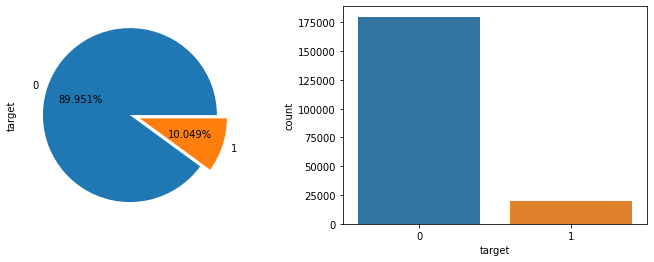

In [ ]:
f,ax=plt.subplots(1,2, figsize=(12,4))
train_df.target.value_counts().plot.pie(explode=[0,0.12],autopct='%1.3f%%',ax=ax[0])
sns.countplot('target',data=train_df)
plt.show()

It can be clearly seen from above diagram that data is imbalance



### **Checking data type of each feature**

In [ ]:
# data type of first column
X_train.dtypes[0]

dtype('float64')

In [ ]:
#it returns true if all the columns have the same data type.
all(x == X_train.dtypes[0] for x in X_train.dtypes)

True

Note: All features are numerical

### Train & test data basic stats

In [ ]:
train_df.describe()

target          var_0  ...        var_198        var_199
count  200000.000000  200000.000000  ...  200000.000000  200000.000000
mean        0.100490      10.679914  ...      15.870720      -3.326537
std         0.300653       3.040051  ...       3.010945      10.438015
min         0.000000       0.408400  ...       6.299300     -38.852800
25%         0.000000       8.453850  ...      13.829700     -11.208475
50%         0.000000      10.524750  ...      15.934050      -2.819550
75%         0.000000      12.758200  ...      18.064725       4.836800
max         1.000000      20.315000  ...      26.079100      28.500700

[8 rows x 201 columns]

In [ ]:
test_df.describe()

var_0          var_1  ...        var_198        var_199
count  200000.000000  200000.000000  ...  200000.000000  200000.000000
mean       10.658737      -1.624244  ...      15.869184      -3.246342
std         3.036716       4.040509  ...       3.008717      10.398589
min         0.188700     -15.043400  ...       6.584000     -39.457800
25%         8.442975      -4.700125  ...      13.847275     -11.124000
50%        10.513800      -1.590500  ...      15.943400      -2.725950
75%        12.739600       1.343400  ...      18.045200       4.935400
max        22.323400       9.385100  ...      26.538400      27.907400

[8 rows x 200 columns]

observations :

* standard deviation is relatively large for both train and test variable data;
* min,max & percentiles shows there is almost no outliers here.
* min, max, mean, sdt values for train and test data looks quite close;
* mean values for some features are in negative(-20) where as for some variables it is high positive(+30) number....that can be seen in below digrams.
* It is pretty uncommon to have such a quantity (200 features) of similar variables, with means and standard deviations of more or less the same magnitude.
* Different plots are plotted below on above keeping above stats in mind.

### **Checking For Missing Values & duplicates rows**

In [ ]:
#Pandas treat None and NaN as essentially interchangeable for indicating missing or null values.
Total_occurence_of_null_values=train_df.isnull().sum().sum()
print("Total occurence of null/missing values in training data =",Total_occurence_of_null_values)

Total_occurence_of_null_values=test_df.isnull().sum().sum()
print("Total occurence of null/missing values in test data =",Total_occurence_of_null_values)

Total occurence of null/missing values in training data = 0
Total occurence of null/missing values in test data = 0


Note:Checking Duplication based on all column values

In [ ]:
duplicateRowsDF = train_df[train_df.duplicated(keep='last')]
print("Duplicate Rows except last occurrence based on all columns are :\n")
if duplicateRowsDF.shape[0]==0:
  print("There is no duplication  in training data")
else:
  print(duplicateRowsDF)

duplicateRowsDF = test_df[test_df.duplicated(keep='last')]

if duplicateRowsDF.shape[0]==0:
  print("There is no duplication in test data")
else:
  print(duplicateRowsDF)

Duplicate Rows except last occurrence based on all columns are :

There is no duplication  in training data
There is no duplication in test data


### Distribution of mean per row in train & test data

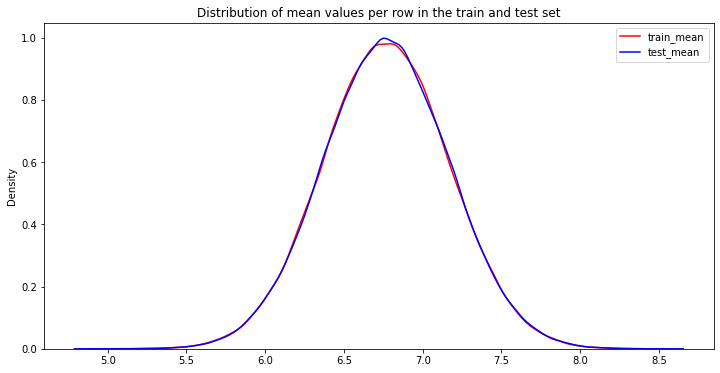

In [ ]:
plt.figure(figsize=(12,6))
plt.title("Distribution of mean values per row in the train and test set")
mean_per_row_train=train_df[col].mean(axis=1)
mean_per_row_test=test_df[col].mean(axis=1)
sns.kdeplot(mean_per_row_train,color='r',label='train_mean')
sns.kdeplot(mean_per_row_test,color='b',label='test_mean')
plt.legend()
plt.show()


* Major overlapping is observed,train & test have same mean per row.

### Distribution of mean per column in train & test data

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


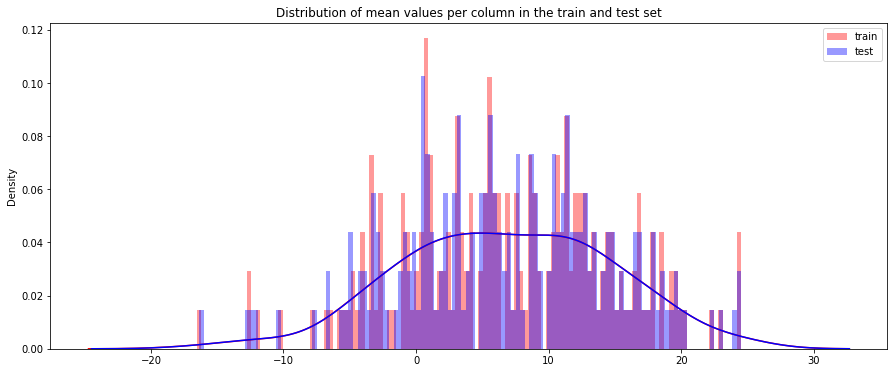

In [ ]:
plt.figure(figsize=(15,6))
plt.title("Distribution of mean values per column in the train and test set")
mean_per_col_train=train_df[col].mean(axis=0)
mean_per_col_test=test_df[col].mean(axis=0)
sns.distplot(mean_per_col_train,color="r",kde=True,bins=120, label='train')
sns.distplot(mean_per_col_test,color="b", kde=True,bins=120, label='test')
plt.legend()
plt.show()


* Major overlapping is observed,train & test have same mean per column.

### Distribution of standard deviation per row  in train & test data

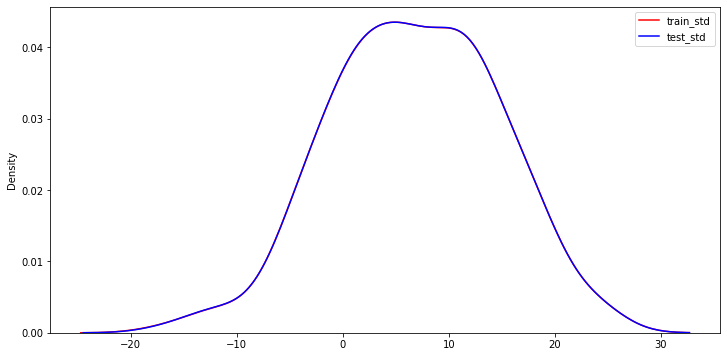

In [ ]:
plt.figure(figsize=(12,6))
std_per_row_train=train_df[col].std(axis=1)
std_per_row_test=test_df[col].std(axis=1)
sns.kdeplot(mean_per_row_train,color='r',label='train_std')
sns.kdeplot(mean_per_row_test,color='b',label='test_std')
plt.legend()
plt.show()


*  Major overlapping is observed,train & test have same st per row.
* std deviations varying from -20 to 30.

### Distribution of standard deviation per column  in train & test data

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


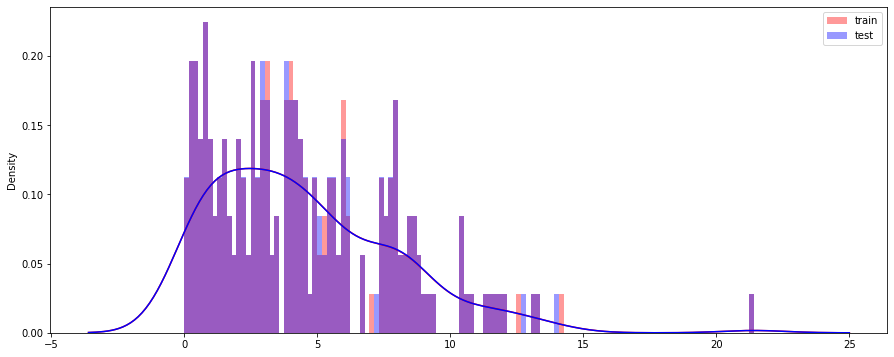

In [ ]:
plt.figure(figsize=(15,6))

std_per_col_train=train_df[col].std(axis=0)
std_per_col_test=test_df[col].std(axis=0)

sns.distplot(std_per_col_train,color="r",kde=True,bins=120, label='train')
sns.distplot(std_per_col_test,color="b", kde=True,bins=120, label='test')
plt.legend()
plt.show()


* perfectly overlapping
* std deviation varying from -5 to 25 

### Distribution of mean per row in train dataset at different target values

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


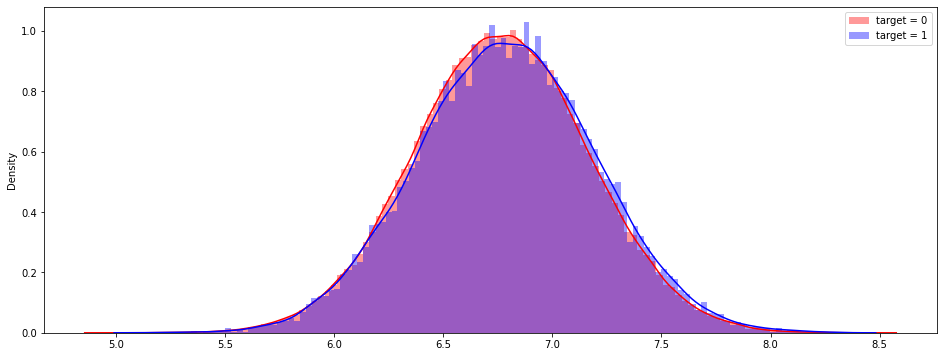

In [ ]:
plt.figure(figsize=(16,6))
sns.distplot(train_df_0[col].mean(axis=1),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(train_df_1[col].mean(axis=1),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

* Major overlapping is observed,so we can not clearly say about the dependency of mean per row  on target.
* A rough estimate that mean per row between 6.3-6.9 have a slightly higher rate of predicting target 0 and mean per row between 7-8.5  have a slightly higher rate of predicting target 1.


### Distribution of mean per col in train dataset at different target values

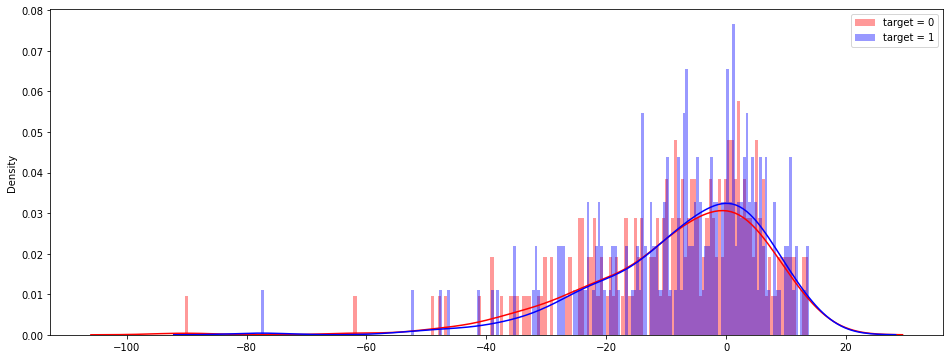

In [ ]:
plt.figure(figsize=(16,6))
sns.distplot(train_df_0[col].min(axis=0),color="red", kde=True,bins=200, label='target = 0')
sns.distplot(train_df_1[col].min(axis=0),color="blue", kde=True,bins=200, label='target = 1')
plt.legend()
plt.show()

* mean b/w 0 to 15 then higher will be chance of predicting target 1
* mean less then -20 then higher willl be the chance of predicting target 0

 ### Distribution of standard deviation per row in train dataset at different target values

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


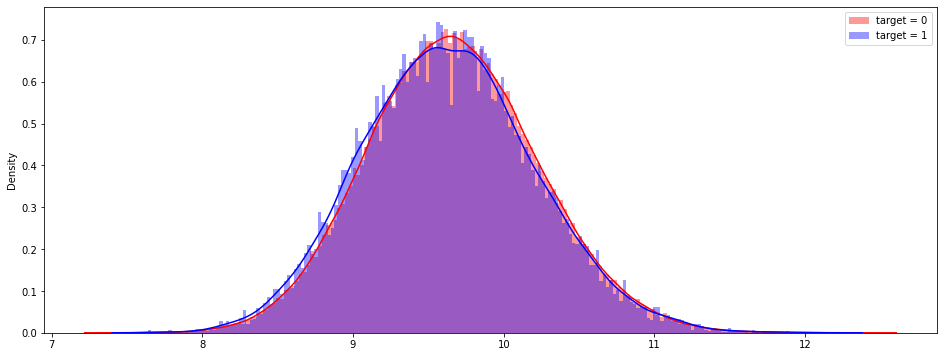

In [ ]:
plt.figure(figsize=(16,6))
sns.distplot(train_df_0[col].std(axis=1),color="red", kde=True,bins=200, label='target = 0')
sns.distplot(train_df_1[col].std(axis=1),color="blue", kde=True,bins=200, label='target = 1')
plt.legend()
plt.show()

* Major overlapping is observed,so we can not clearly say about the dependency of std per row  on target.
* A rough estimate that std per row between 6-9.5 have a slightly higher rate of predicting target 1 and mean per row between 9.5-11  have a slightly higher rate of predicting target 0.


 ### Distribution of standard deviation per column in train dataset at different target values

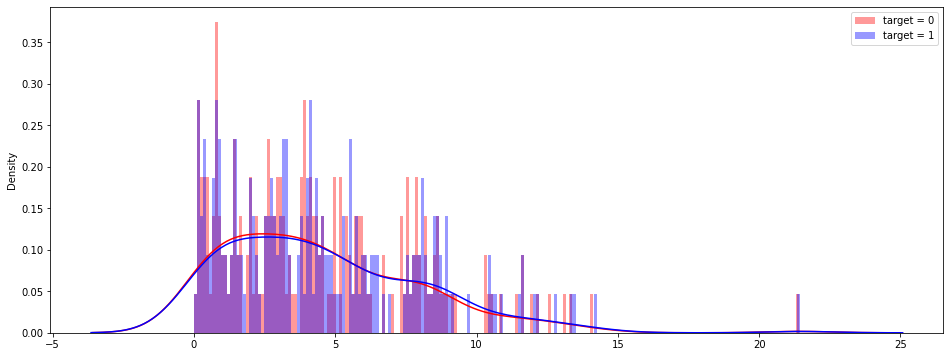

In [ ]:
plt.figure(figsize=(16,6))
sns.distplot(train_df_0[col].std(axis=0),color="red", kde=True,bins=200, label='target = 0')
sns.distplot(train_df_1[col].std(axis=0),color="blue", kde=True,bins=200, label='target = 1')
plt.legend()
plt.show()

* Major overlapping is observed,so we can not clearly say about the dependency of std per col  on target.
* A rough estimate that std per col between 0-4 have a slightly higher rate of predicting target 0 and std per col between 8-11  have a slightly higher rate of predicting target 1.


### Ditribution of minimum value per row grouped on target variable

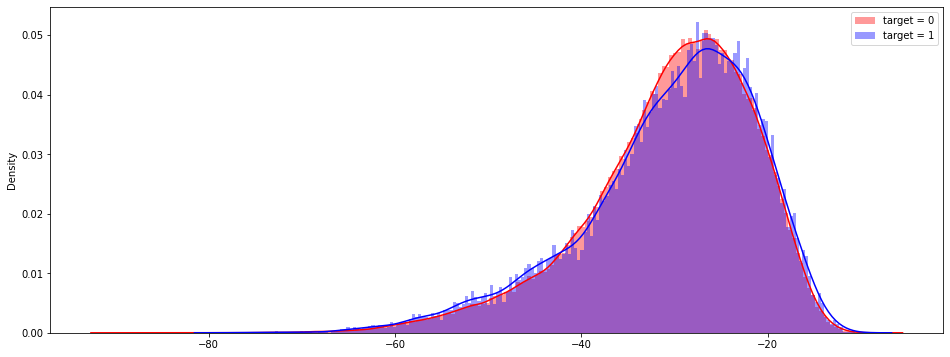

In [ ]:
plt.figure(figsize=(16,6))
sns.distplot(train_df_0[col].min(axis=1),color="red", kde=True,bins=200, label='target = 0')
sns.distplot(train_df_1[col].min(axis=1),color="blue", kde=True,bins=200, label='target = 1')
plt.legend()
plt.show()

* Slight unoverlapping says that this new feature 'minimum' maybe more  useful then previous ones. 
* A rough estimate that min per row between -80 to -35 have a slightly higher rate of predicting target 1 and min per row between -35 to -15 have a slightly higher rate of predicting target 0.
* left skewness may lead to overfitting/outliers(not sure)

### Ditribution of minimum value per column grouped on target variable

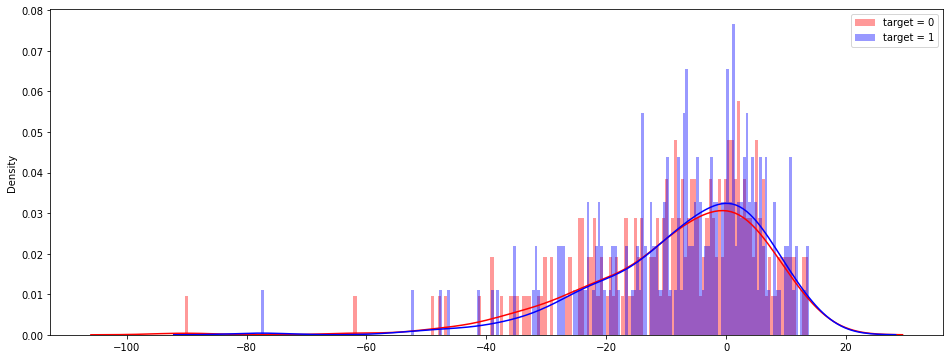

In [ ]:
plt.figure(figsize=(16,6))
sns.distplot(train_df_0[col].min(axis=0),color="red", kde=True,bins=200, label='target = 0')
sns.distplot(train_df_1[col].min(axis=0),color="blue", kde=True,bins=200, label='target = 1')
plt.legend()
plt.show()

* Slight unoverlapping says that this new feature 'minimum' maybe useful 


### Distribution of maximum value per row grouped on target variable

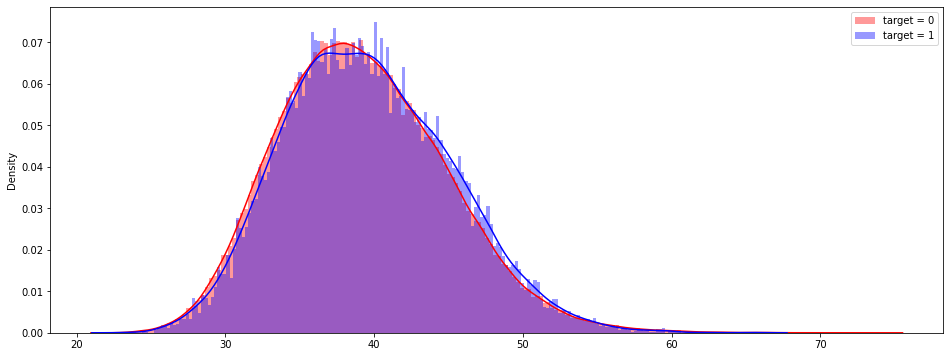

In [ ]:
plt.figure(figsize=(16,6))
sns.distplot(train_df_0[col].max(axis=1),color="red", kde=True,bins=200, label='target = 0')
sns.distplot(train_df_1[col].max(axis=1),color="blue", kde=True,bins=200, label='target = 1')
plt.legend()
plt.show()

* Slight unoverlapping says that this new feature 'maximum' maybe useful 
* value greater then near 70 are taget_0

In [ ]:
a=train_df.loc[train_df[col].max(axis=1)>68]

In [ ]:
a['target'].value_counts()

0    8
Name: target, dtype: int64

### Distribution of maximum value per column grouped on target variable

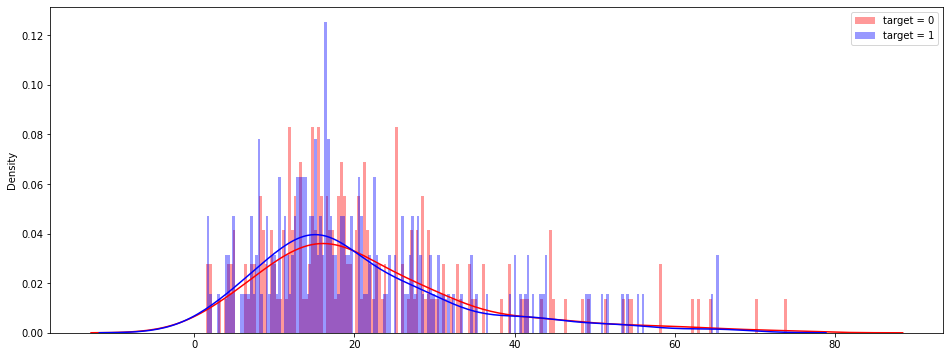

In [ ]:
plt.figure(figsize=(16,6))
sns.distplot(train_df_0[col].max(axis=0),color="red", kde=True,bins=200, label='target = 0')
sns.distplot(train_df_1[col].max(axis=0),color="blue", kde=True,bins=200, label='target = 1')
plt.legend()
plt.show()

* not completly overlapping
* right skewed

* train & test distribution are almost overlapping to each other which shows both have almost same data
* Result on train & test should not vary much

### **Distribution of train data based on target(0&1)**

In [ ]:
col=[f'var_{i}' for i in range(200)]

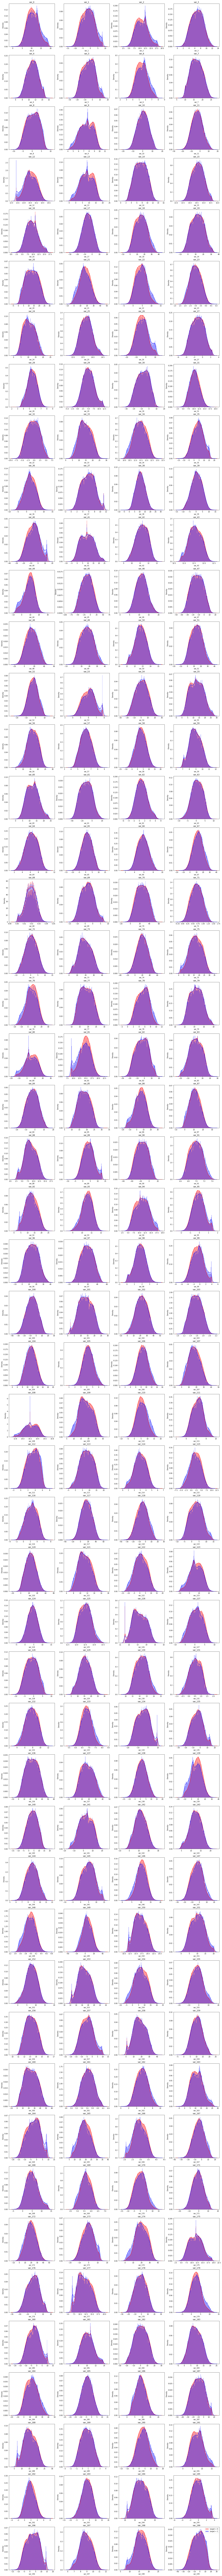

In [ ]:
c=1
plt.subplots(figsize=(24, 300))
for i in col:
  plt.subplot(50,4,c)
  plt.title(f'var_{c-1}') 
  sns.distplot(train_df_0[i],color="red", kde=True,bins=120, label='target = 0')
  sns.distplot(train_df_1[i],color="blue", kde=True,bins=120, label='target = 1')   
  c=c+1
plt.legend()
plt.show()


* Each of the 200 features are almost overlapping (when hue ="target")  but not fully overlapping 
* **Overlapping** shows that single feature might not be helpful classify the target label
* But few unoverlapped area shows that still some of the information can be used from these features to classify between target_0 & target_1 
* Since the skewness of all the graphs are neglisible ....we can say that there is no outliers in data

### **Feature Importance using LGBM**

In [ ]:
#parameter are choosed such that model get highest accuracy on training data i.e. overfitting
param = {
         'objective': 'binary',
         'metric': 'None',
         'learning_rate': 0.01, #Learning rate is low because we are using very high n_estimators
         'max_depth': -1,
         'num_leaves': 2**6 -1, #making it large so that every feature can be used
         'max_bin': 255,
         'min_child_weight': 10,
         'min_data_in_leaf': 150,
         'reg_lambda': 0.5,  # L2 regularization term on weights.
         'reg_alpha': 0.5,  # L1 regularization term on weights.
         'colsample_bytree': 0.5,
         'subsample': 0.7,
         'bagging_freq': 5,
         'verbose':-1,
         }

In [ ]:

model=lgb.LGBMClassifier(**param,n_estimators=20000)
model.fit(X_train[:180000],Y_train[:180000])


LGBMClassifier(bagging_freq=5, boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.5, importance_type='split',
               learning_rate=0.01, max_bin=255, max_depth=-1, metric='None',
               min_child_samples=20, min_child_weight=10, min_data_in_leaf=150,
               min_split_gain=0.0, n_estimators=20000, n_jobs=-1, num_leaves=63,
               objective='binary', random_state=None, reg_alpha=0.5,
               reg_lambda=0.5, silent=True, subsample=0.7,
               subsample_for_bin=200000, subsample_freq=0, verbose=-1)

In [ ]:
auc_train=roc_auc_score(Y_train, model.predict_proba(X_train)[:,1])
print(auc_train)

0.9934772171085919


In [ ]:
n=model.feature_importances_        #result contains numbers of times the feature is used in a model
max=n.max()                         #retuns maximum  from all values in array n
split=n/max                         #values lies b/w 0 to 1 for better interperibility

Feat_imp=pd.DataFrame({'Features':col,'Split':split})   #creating dataframe with features and their split value in the model which shows the importance
                                                        #of that feature (higher the better)

In [ ]:
Feat_imp=Feat_imp.sort_values(by='Split',ascending=False)

In [ ]:
Feat_imp

Features     Split
81    var_81  1.000000
174  var_174  0.997972
21    var_21  0.997432
78    var_78  0.987564
177  var_177  0.984320
..       ...       ...
25    var_25  0.698297
129  var_129  0.697621
47    var_47  0.690727
117  var_117  0.683428
185  var_185  0.667478

[200 rows x 2 columns]

* When we trained our model such that gives almost 100% accuracy on train data.
* Then we find the feature importance(named as Split) using split as importance_type.
* Split values lie between 0.667478 to 1 for all features. Which is very good so we are not dropping any features.


### **Correlation**

In [ ]:
train_df.shape

(200000, 202)

In [ ]:
corr=train_df.iloc[:,2:200].corr()

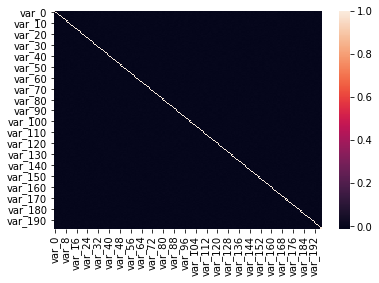

In [ ]:
sns.heatmap(corr)

* correlation value between any features is almost 0 that can be observed through heatmap.
* So we can use these features on linear models(LR,SVM) & get feature importance

### scatter plot

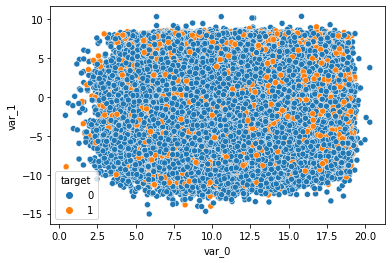

In [ ]:
sns.scatterplot(data=train_df,x='var_0',y='var_1',hue='target')

Observation:
* above scatterplot does not make any sense; 
* It looks like randomly some points are red and some are blue
* Non separable linearly

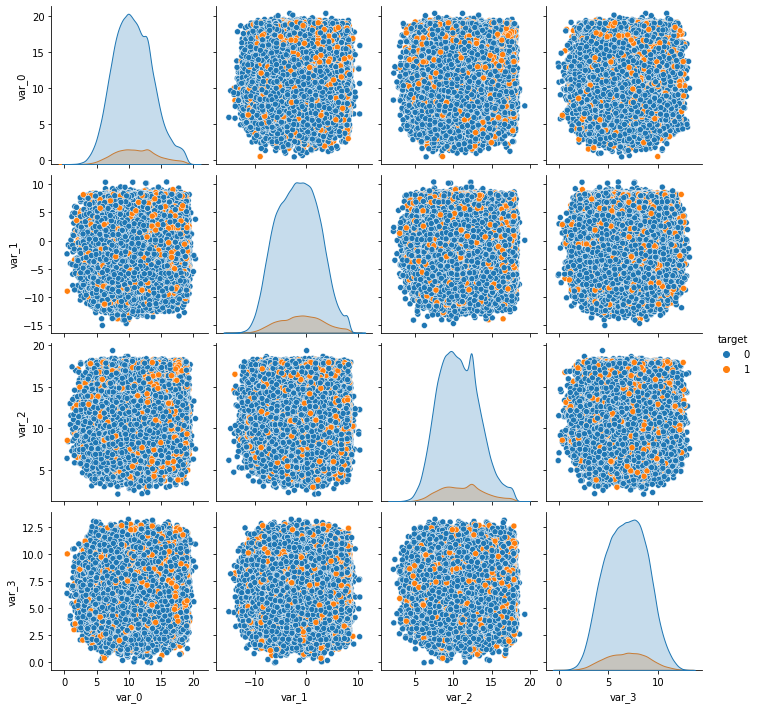

In [ ]:
sns.pairplot(data=train_df.loc[:,['var_0','var_1','var_2','var_3','target']],hue='target')

* Scatterplot between two varibale not giving much information

### **Checking for Variability in Train & Test data**

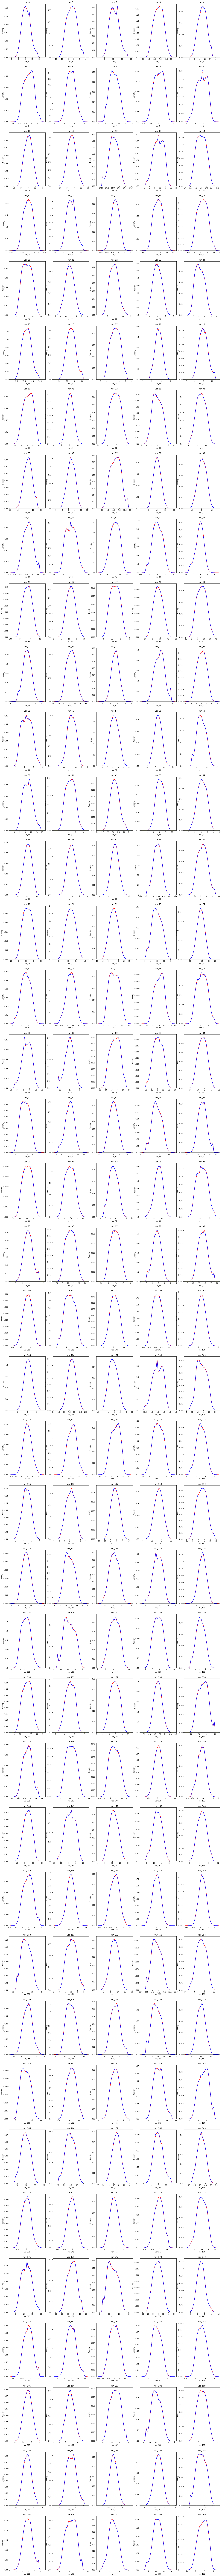

In [ ]:
col=[f'var_{}' i in range(200)]
c=1
plt.subplots(figsize=(24, 300))
for i in col:
  plt.subplot(40,5,c)
  plt.title(i)
  plt.xlabel(i)
  sns.kdeplot(X_train[i],color='r',label='train_data')
  sns.kdeplot(X_test[i],color='b',label='test_data')
  c=c+1
plt.legend()
plt.show()

* Major overlapping is observed, train & test data are almost same.
* That means there should be not big difference between train & test accuracy

### **Catching the pattern of unique values in features**

In [ ]:
len(train_df['var_0'].unique())


94672

In [ ]:
len(test_df['var_0'].unique())

65580

* Mean,std,min,max all the basic stats of train & test are almost same
* But the number of unique values is significantly different between training set and test set.
* Lets see the distribution unique values of train & test data

>> Distribution of the number of unique values (across features) across train & test dataset

In [ ]:
col=[f'var_{i}' for i in range(200)]

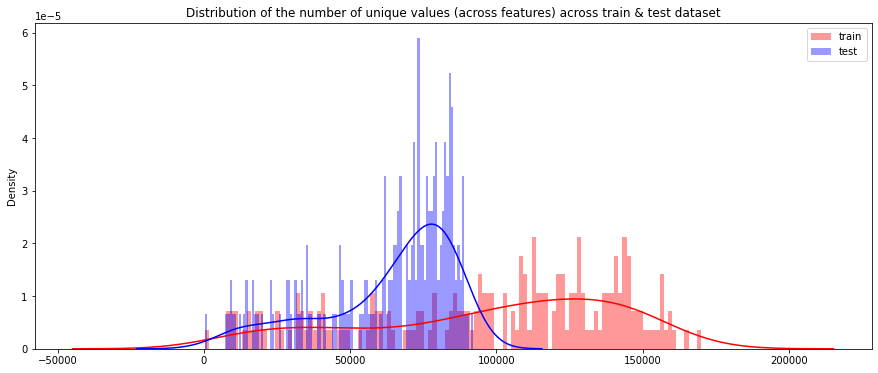

In [ ]:
plt.figure(figsize=(15,6))

nuniq_per_col_train=train_df[col].nunique(axis=0)
nuniq_per_col_test=test_df[col].nunique(axis=0)
plt.title('Distribution of the number of unique values (across features) across train & test dataset')
sns.distplot(nuniq_per_col_train,color="r",kde=True,bins=120, label='train')
sns.distplot(nuniq_per_col_test,color="b", kde=True,bins=120, label='test')
plt.legend()
plt.show()


* from the above distribution of unique values per column on train & test data ,we can say that very less unique values are used in test in compare to train instead of having similar statistic b/w them.

## Feature Engineering

In [ ]:
scaler=StandardScaler()             #scaling
scaler.fit(train_df.iloc[:,2:202])  #Fitting on train data 
train_df.iloc[:,2:202]=scaler.transform(train_df.iloc[:,2:202])  #standasrd scaling all the train data

In [ ]:
test_df.iloc[:,1:201]=scaler.transform(test_df.iloc[:,1:201])     #standasrd scaling all the test data

### **Checking For fake data in test dataset**

In [ ]:
col_names=[f'var_{i}' for i in range(200)]        #All 200 column names
for col in tqdm(col_names):
  count=test_df[col].value_counts()               #return a series containing count of unique values
  uniques=count.index[count==1]                   #elements which has count=1
  test_df[col+'_uniq']=test_df[col].isin(uniques) #Creating new features having value '1' for if the element is unique among all the values 
                                                  #in its column else '0'

#It will create a feature  'any_unique'  
#which will assign value of 1 if any of the {var_0,var_1,.....var_199} features have unique entries in that row else 0
test_df['any_unique']=test_df[[col +'_uniq' for col in col_names]].any(axis=1)
  

100%|██████████| 200/200 [00:04<00:00, 44.99it/s]


In [ ]:
uniq=test_df['any_unique'].sum()                 #counting rows atleast having one unique value
fake=test_df.shape[0]-uniq
print("There are {0}  fake rows in test dataset which is {1}% of the test data".format(fake,(fake/test_df.shape[0])*100))

There are 100000  fake rows in test dataset which is 50.0% of the test data


### **Checking for fake data in train dataset**

In [ ]:
col_names=[f'var_{i}' for i in range(200)]
for col in tqdm(col_names):
  count=train_df[col].value_counts()
  uniques=count.index[count==1]
  train_df[col+'_uniq']=train_df[col].isin(uniques)
  
train_df['any_unique']=train_df[[col +'_uniq' for col in col_names]].any(axis=1)
  

100%|██████████| 200/200 [00:06<00:00, 29.49it/s]


In [ ]:
uniq=train_df['any_unique'].sum()
fake=train_df.shape[0]-uniq

print("There are {0}  fake rows in train dataset which is {1}% of the train dataset".format(fake,(fake/train_df.shape[0])*100))


There are 0  fake rows in train dataset which is 0.0% of the train dataset
